In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from statsmodels.stats import weightstats

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

In [2]:
stud_math = pd.read_csv('stud_math.csv')

In [3]:
trash_list = []

In [4]:
need_list = []

In [5]:
# предобработка

df = stud_math.copy()

# переименуем колонки для удобства
df.columns = ('school', 'sex', 'age', 'address', 'famsize',
              'p_status', 'm_edu', 'f_edu', 'm_job', 'f_job',
              'reason', 'guardian', 'traveltime', 'studytime',
              'failures', 'schoolsup', 'famsup', 'paid',
              'activities', 'nursery', 'studytime_granular',
              'higher', 'internet', 'romantic', 'famrel',
              'freetime', 'goout', 'health', 'absences', 'score')


# удалим пропущенные значения в переменной score
delete_df = df[df.score.isna()]
df = df.drop(delete_df.index)


def outliers_check(sample):
    ''' The function takes Pandas.Series
        then calculate outliers 
        and return df with them '''

    Q1 = sample.quantile(0.25)
    Q3 = sample.quantile(0.75)
    IQR = Q3 - Q1
    temp_df = pd.DataFrame(sample)
    temp_df['up_outliers'] = pd.Series(sample > (Q3 + IQR*1.5))
    temp_df['down_outliers'] = pd.Series(sample < (Q1 - IQR*1.5))

    if temp_df.up_outliers.nunique() == 1 and temp_df.down_outliers.nunique() == 1:
        return print('Выбросы не найдены')
    else:
        return temp_df[(temp_df.down_outliers == True) | (temp_df.up_outliers == True)]


def free_outliers_hist(sample, title, xlabel):
    ''' The function takes Pandas.Series,
        calculate outliers,
        then draw a histogram without them'''

    Q1 = sample.quantile(0.25)
    Q3 = sample.quantile(0.75)
    IQR = Q3 - Q1

    sample.loc[sample.between(Q1 - 1.5*IQR,
                              Q3 + 1.5*IQR)].hist(bins=10, label=title)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('frequence', fontsize=12)
    plt.legend()


def delite_outliers(sample):
    ''' The function takes Pandas.Series,
        then calculate outliers 
        and return Pandas.Series without them '''

    Q1 = sample.quantile(0.25)
    Q3 = sample.quantile(0.75)
    IQR = Q3 - Q1
    temp_df = pd.DataFrame(sample)
    temp_df['up_outliers'] = pd.Series(sample > (Q3 + IQR*1.5))
    temp_df['down_outliers'] = pd.Series(sample < (Q1 - IQR*1.5))
    temp_df = temp_df[(temp_df['up_outliers'] == False) &
                      (temp_df['down_outliers'] == False)]

    return sample[temp_df.index]

### 1. Осмотр данных и проверка на пустые значения

In [6]:
display(df.head(10))
df.info()

,school,sex,age,address,famsize,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   school              389 non-null    object 
 1   sex                 389 non-null    object 
 2   age                 389 non-null    int64  
 3   address             374 non-null    object 
 4   famsize             362 non-null    object 
 5   p_status            344 non-null    object 
 6   m_edu               386 non-null    float64
 7   f_edu               365 non-null    float64
 8   m_job               370 non-null    object 
 9   f_job               353 non-null    object 
 10  reason              372 non-null    object 
 11  guardian            358 non-null    object 
 12  traveltime          361 non-null    float64
 13  studytime           382 non-null    float64
 14  failures            367 non-null    float64
 15  schoolsup           380 non-null    object 
 16  famsup  

In [7]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
age,389.0,16.673522,1.265662,15.0,16.0,17.0,18.0,22.0
m_edu,386.0,2.766839,1.094277,0.0,2.0,3.0,4.0,4.0
f_edu,365.0,2.627397,2.241790,0.0,2.0,3.0,3.0,40.0
traveltime,361.0,1.434903,0.692660,1.0,1.0,1.0,2.0,4.0
studytime,382.0,2.036649,0.847239,1.0,1.0,2.0,2.0,4.0
failures,367.0,0.326975,0.729479,0.0,0.0,0.0,0.0,3.0
studytime_granular,382.0,-6.109948,2.541716,-12.0,-6.0,-6.0,-3.0,-3.0
famrel,362.0,3.930939,0.931554,-1.0,4.0,4.0,5.0,5.0
freetime,380.0,3.223684,0.993364,1.0,3.0,3.0,4.0,5.0
goout,382.0,3.094241,1.116104,1.0,2.0,3.0,4.0,5.0


In [8]:
df.isna().sum()

school                 0
sex                    0
age                    0
address               15
famsize               27
p_status              45
m_edu                  3
f_edu                 24
m_job                 19
f_job                 36
reason                17
guardian              31
traveltime            28
studytime              7
failures              22
schoolsup              9
famsup                38
paid                  39
activities            14
nursery               15
studytime_granular     7
higher                20
internet              34
romantic              31
famrel                27
freetime               9
goout                  7
health                15
absences              11
score                  0
dtype: int64

In [9]:
df.score.unique()

array([ 30.,  50.,  75.,  55.,  95.,  45.,  60.,  70.,  80.,  25.,  40.,
        85.,  90.,  65., 100.,  35.,   0.,  20.])

Обнаружена переменная, которой нет в описании studytime, granular.  
Обнаружено 6 пустых значений в переменной score - отвечающей за успеваемость, т.к. это целевая переменная, необходимо удалить эти значения. __Убрано в предобработку.__   
Но для начала приведём названия переменных в более удобный вид. __Убрано в предобработку.__ 

In [10]:
# проверяем удаление
print(f'Количество пустых значений в переменной score = {len(df[df.score.isna()])}')
df.info()

Количество пустых значений в переменной score = 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   school              389 non-null    object 
 1   sex                 389 non-null    object 
 2   age                 389 non-null    int64  
 3   address             374 non-null    object 
 4   famsize             362 non-null    object 
 5   p_status            344 non-null    object 
 6   m_edu               386 non-null    float64
 7   f_edu               365 non-null    float64
 8   m_job               370 non-null    object 
 9   f_job               353 non-null    object 
 10  reason              372 non-null    object 
 11  guardian            358 non-null    object 
 12  traveltime          361 non-null    float64
 13  studytime           382 non-null    float64
 14  failures            367 non-null    float64
 15  schools

### 2. Анализ данных в столбцах


#### score
Целевая переменная. Пропуски в ней уже удалены. Оценим распределение значений.

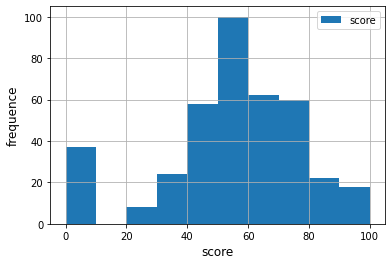

In [11]:
df.score.hist(label='score')
plt.xlabel('score', fontsize=12)
plt.ylabel('frequence', fontsize=12)
# plt.title('')
plt.grid(True)
plt.legend()
plt.show()

In [12]:
nul_score = df[df['score'] == 0].copy()
len(nul_score)

37

Имеется 37 оценок 0, т.к. переменная целевая, данные менять нельзя, удалять пока тоже не будем, т.к. причина такой оценки не известна. М.б. ученик не участвовал в экзамене по какой-то причине, а м.б. провалился. Разделить эти причины не предоставляется возможным.

#### school
Переменная категориальная.  
В переменной нет пустых значений.

In [13]:
df.school.nunique()

2

In [14]:
df.school.unique()

array(['GP', 'MS'], dtype=object)

In [15]:
df.school.value_counts()

GP    344
MS     45
Name: school, dtype: int64

Итого в наборе данных представлены ученики из двух школ.  
Посмотрим, влияет ли эта переменная на итоговую успеваемость или, другими словами, оценим различается ли качество преподавания в разных школах?  
Для этого сначала оценим распределение частоты оценок в зависимости отшколы и выясним есть ли выбросы.

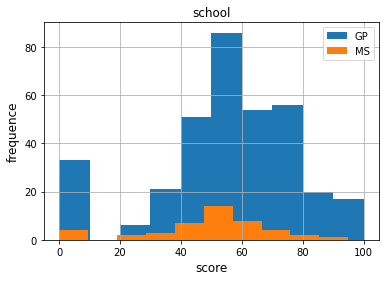

In [16]:
GP = df[df.school == 'GP'].score.copy()
MS = df[df.school == 'MS'].score.copy()
GP.hist(label='GP')
MS.hist(label='MS')
plt.xlabel('score', fontsize=12)
plt.ylabel('frequence', fontsize=12)
plt.title('school')
plt.grid(True)
plt.legend()
plt.show()

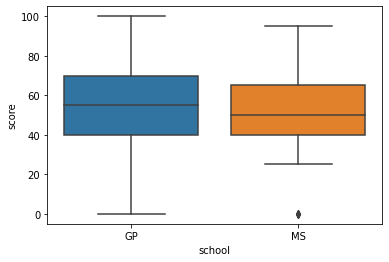

In [17]:
sns.boxplot(x='school', y='score', data=df)

Распределение оценок в школах схожее, похоже что нет разницы в качестве обучения.  
Необходимо проверить с помощью теста Стьюдента.

In [18]:
# проверим есть ли выбросы
outliers_check(GP)

Выбросы не найдены


In [19]:
outliers_check(MS)

,score,up_outliers,down_outliers
367,0.0,False,True
383,0.0,False,True
387,0.0,False,True
389,0.0,False,True


Найдены выбросы в распеределении оценок в группе MS.  
Посмотрим, как выглядят на гистограммы распределения с выбросами и без.

25-й перцентиль GP: 40.0, 75-й перцентиль GP: 70.0, GP_IQR: 30.0,  Границы выбросов: [-5.0, 115.0].



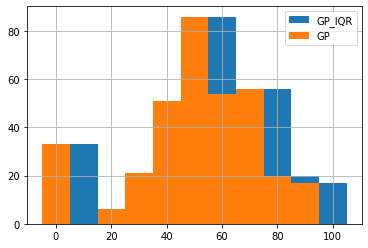

In [20]:
GP_Q1 = GP.quantile(0.25)
GP_Q3 = GP.quantile(0.75)
GP_IQR = GP_Q3 - GP_Q1

print(
    '25-й перцентиль GP: {},'.format(GP_Q1),
    '75-й перцентиль GP: {},'.format(GP_Q3),
    "GP_IQR: {}, ".format(GP_IQR),
    "Границы выбросов: [{f}, {l}].\n".format(f=GP_Q1 - 1.5*GP_IQR, l=GP_Q3 + 1.5*GP_IQR))

GP.loc[GP.between(
    GP_Q1 - 1.5*GP_IQR,
    GP_Q3 + 1.5*GP_IQR)].hist(bins=10, range=(0, 100), label='GP_IQR', align='right')
GP.hist(label='GP', bins=10, align='left')
plt.legend()

25-й перцентиль MS: 40.0, 75-й перцентиль MS: 65.0, MS_IQR: 25.0,  Границы выбросов: [2.5, 102.5].


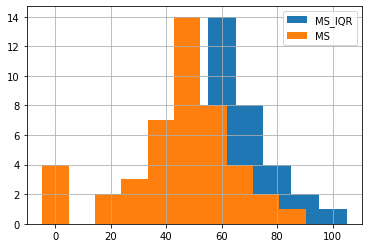

In [21]:
MS_Q1 = MS.quantile(0.25)
MS_Q3 = MS.quantile(0.75)
MS_IQR = MS_Q3 - MS_Q1

print(
    '25-й перцентиль MS: {},'.format(MS_Q1),
    '75-й перцентиль MS: {},'.format(MS_Q3),
    "MS_IQR: {}, ".format(MS_IQR),
    "Границы выбросов: [{f}, {l}].".format(f=MS_Q1 - 1.5*MS_IQR, l=MS_Q3 + 1.5*MS_IQR))

MS.loc[MS.between(
    MS_Q1 - 1.5*MS_IQR,
    MS_Q3 + 1.5*MS_IQR)].hist(bins=10, range=(0, 100), label='MS_IQR', align='right')
MS.hist(label='MS', bins=10, align='left')
plt.legend()

Для Т-теста заменим выбросы в группе MS на медианое значение.

In [22]:
# заменяем выбросы на медиану
df_temp = df.copy()
df_temp.loc[((df_temp['school'] == 'MS') & (df_temp['score'] == 0)), [
    'score']] = MS.quantile(0.5)
# проверяем изменения
# индексы строк с выбросамии для группы MS
df_temp[df_temp.index.isin([367, 383, 387, 389])]

,school,sex,age,address,famsize,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
367,MS,F,17,R,NaN,T,1.0,1.0,other,services,reputation,mother,3.0,1.0,1.0,no,yes,yes,no,yes,-3.0,yes,yes,yes,5.0,2.0,1.0,1.0,0.0,50.0
383,MS,M,19,R,GT3,T,1.0,1.0,other,services,other,mother,2.0,1.0,1.0,no,no,no,no,NaN,-3.0,yes,no,no,4.0,3.0,2.0,5.0,0.0,50.0
387,MS,F,19,R,GT3,T,2.0,3.0,services,other,course,mother,1.0,3.0,1.0,no,no,no,yes,no,-9.0,yes,yes,no,5.0,4.0,2.0,5.0,0.0,50.0
389,MS,F,18,U,GT3,T,1.0,1.0,other,other,course,mother,NaN,2.0,1.0,no,no,no,yes,yes,-6.0,yes,NaN,no,1.0,1.0,1.0,5.0,0.0,50.0


Воспользуемся Т-тестом для оценки значимости различий между оценками полученными в разных школах.
Т.к. выборки достаточно большие и случайные, согласно центральной предельной теореме мы можем считать что их распределение приблизительно нормальное. 

In [23]:
# обновляем значение переменной
MS = df_temp[df_temp.school == 'MS'].score.copy()
weightstats.ttest_ind(GP, MS)  # T test для выборки

(-0.35562179318461723, 0.7223175780510509, 387.0)

p-value = 0.72, нулевая гипотеза подтверждается, между средними выборок нет различий.  
Можно предположить, что уровень преподавания в этих школах одинаковый.    
А значит сама эта переменная не влияет на целевую.  
В дальнейшем, исключим её из датасета, а пока добавим её название в список на исключение.

In [24]:
trash_list.append('school')
trash_list

['school']

#### sex
sex — пол ученика ('F' - женский, 'M' - мужской)

In [25]:
display(df.sex.nunique())
display(df.sex.unique())
display(df.sex.value_counts())

2

array(['F', 'M'], dtype=object)

F    204
M    185
Name: sex, dtype: int64

Пропусков нет, два уникальных значения. Девочек немного больше чем мальчиков.  
Оценим, влияет ли пол на успеваемость?

In [26]:
# сгуппируем оценки по полу
f = df[df.sex == 'F'].score.copy()
m = df[df.sex == 'M'].score.copy()

In [27]:
outliers_check(m)  # выбросы у мальчиков

,score,up_outliers,down_outliers
128,0.0,False,True
134,0.0,False,True
136,0.0,False,True
140,0.0,False,True
144,0.0,False,True
148,0.0,False,True
150,0.0,False,True
153,0.0,False,True
160,0.0,False,True
162,0.0,False,True


In [28]:
outliers_check(f)  # выбросы у девочек

,score,up_outliers,down_outliers
130,0.0,False,True
131,0.0,False,True
135,0.0,False,True
137,0.0,False,True
146,0.0,False,True
168,0.0,False,True
173,0.0,False,True
221,0.0,False,True
259,0.0,False,True
264,0.0,False,True


В обоих группах нулевые значения оценок являются выбросами.

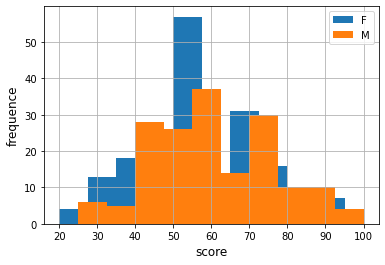

In [29]:
free_outliers_hist(f, 'F', 'score')
free_outliers_hist(m, 'M', 'score')

In [30]:
# оценимним есть ли статистически значимые различия в оценках между M и F без выбросов.
weightstats.ttest_ind(delite_outliers(
    f), delite_outliers(m))  # T test для выборки

(-1.9267806670436756, 0.054816294332242284, 350.0)

p-value 0.055, нулевая гипотеза подтверждается, различия не значимы.  
В дальнейшем, исключим её из датасета, а пока добавим её название в список на исключение.

In [31]:
trash_list.append('sex')
trash_list

['school', 'sex']

#### Age

Переменная числовая, не содержит пропусков.

In [32]:
print(f'Количество уникальных значений возрата учеников = {df.age.nunique()}')
print(f'Уникальные значения возраcта учеников {df.age.unique()}')
print(df.age.value_counts())

Количество уникальных значений возрата учеников = 8
Уникальные значения возраcта учеников [18 17 15 16 19 22 20 21]
16    103
17     98
15     82
18     80
19     21
20      3
22      1
21      1
Name: age, dtype: int64


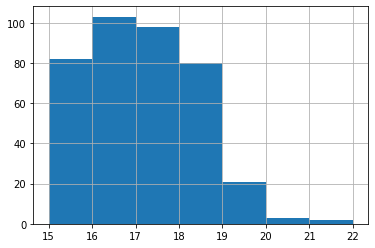

In [33]:
df.age.hist(bins=7)

Распределение асиметричное.

In [34]:
outliers_check(df.age)

,age,up_outliers,down_outliers
247,22,True,False


Оставим выброс = 22 т.к. он удовлетворяет условию задания.
>Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике,

In [35]:
need_list.append('age')

#### address

Категориальная переменная — тип адреса ученика ('U' - городской, 'R' - за городом)  
Содержит 15 пропусков.

In [36]:
df.address.unique()

array(['U', nan, 'R'], dtype=object)

In [37]:
u = df[df.address == 'U'].score.copy()
r = df[df.address == 'R'].score.copy()

In [38]:
outliers_check(u)  # выбросы у городских учеников

,score,up_outliers,down_outliers
131,0.0,False,True
135,0.0,False,True
137,0.0,False,True
140,0.0,False,True
144,0.0,False,True
146,0.0,False,True
148,0.0,False,True
150,0.0,False,True
153,0.0,False,True
162,0.0,False,True


In [39]:
outliers_check(r)  # выбросы у загородных учеников

Выбросы не найдены


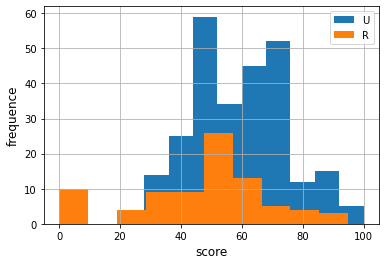

In [40]:
free_outliers_hist(u, 'U', 'score')
free_outliers_hist(r, 'R', 'score')

In [41]:
# оценимним есть ли статистически значимые различия в оценках между U и R без выбросов.
weightstats.ttest_ind(delite_outliers(u), r)  # T test для выборки

(5.234280072765354, 2.879045601106688e-07, 346.0)

In [42]:
weightstats.ttest_ind(u, r)  # T test для выборки

(2.33264133175904, 0.020199635381958233, 372.0)

p-value = 2.88*10^-7  
Можно сделать вывод о том, что городские ученики в целом успешнее показали себя на экзамене.

In [43]:
need_list.append('address')

#### famsize
famsize — размер семьи('LE3' <= 3, 'GT3' >3)  
Категориальная переменная.  
27 пропусков  

In [44]:
df.famsize.unique()

array([nan, 'GT3', 'LE3'], dtype=object)

In [45]:
GT3 = df[df.famsize == 'GT3'].score.copy()
LE3 = df[df.famsize == 'LE3'].score.copy()

In [46]:
outliers_check(GT3)  # выбросы у учеников из большой семьи

Выбросы не найдены


In [47]:
outliers_check(LE3)  # выбросы у учеников из малой семьи

,score,up_outliers,down_outliers
150,0.0,False,True
160,0.0,False,True
162,0.0,False,True
242,0.0,False,True
259,0.0,False,True
310,0.0,False,True
333,0.0,False,True


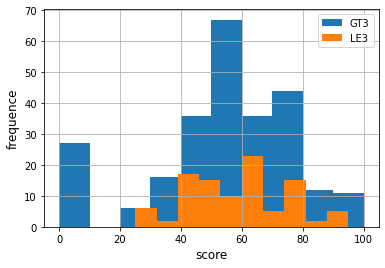

In [48]:
free_outliers_hist(GT3, 'GT3', 'score')
free_outliers_hist(LE3, 'LE3', 'score')

In [49]:
# оценимним есть ли статистически значимые различия в оценках между LE3 и GT3 без выбросов.
weightstats.ttest_ind(delite_outliers(
    LE3), delite_outliers(GT3))  # T test для выборки

(2.740928076392295, 0.006438263594040736, 353.0)

In [50]:
display(delite_outliers(LE3).mean())
display(GT3.mean())

58.5

51.509803921568626

Различия в оценках статистически значимы между учениками малых и больших семей, в пользу LE3.

In [51]:
need_list.append('famsize')

#### Pstatus
Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)
Категориальная переменная.  
45 пропусков

In [52]:
display(df.p_status.unique())
df.p_status.value_counts()

array(['A', nan, 'T'], dtype=object)

T    308
A     36
Name: p_status, dtype: int64

In [53]:
t = df[df.p_status == 'T'].score.copy()
a = df[df.p_status == 'A'].score.copy()

In [54]:
outliers_check(t)  # выбросы у учеников проживающих с родителями

Выбросы не найдены


In [55]:
outliers_check(a)

,score,up_outliers,down_outliers
137,0.0,False,True
343,0.0,False,True


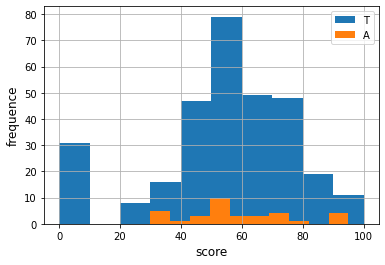

In [56]:
free_outliers_hist(t, 'T', 'score')
free_outliers_hist(a, 'A', 'score')

In [57]:
# оценимним есть ли статистически значимые различия в оценках между T и A без выбросов.
weightstats.ttest_ind(delite_outliers(
    t), delite_outliers(a))  # T test для выборки

(-1.6383042819176197, 0.1022832713863409, 340.0)

P-value = 0.1, нулевая гипотеза не отвергается.  
 
Статус проживания не влияет на оценку.  
Однако P-value не такой уж большой, поэтому переменную убирать не будем. 

In [58]:
need_list.append('p_status')

#### Medu
Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)  
Переменная числовая, ранговая.   
Три пропущенных значения.

In [59]:
display(df.m_edu.unique())
display(df.m_edu.value_counts())

array([ 4.,  1.,  3.,  2., nan,  0.])

4.0    131
2.0    100
3.0     96
1.0     56
0.0      3
Name: m_edu, dtype: int64

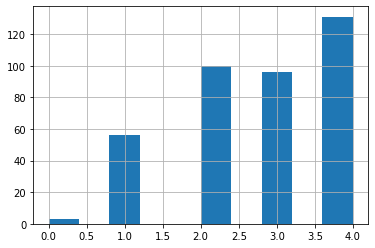

In [60]:
df.m_edu.hist(bins=10)

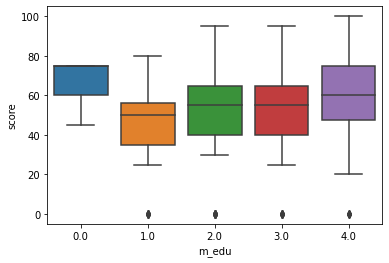

In [61]:
sns.boxplot(x='m_edu', y='score', data=df)

In [62]:
outliers_check(df.m_edu)

Выбросы не найдены


#### Fedu
Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
Переменная числовая, ранговая.
27 пропущенных значений.

array([ 4.,  1.,  2.,  3., 40., nan,  0.])

2.0     105
3.0      94
4.0      88
1.0      75
0.0       2
40.0      1
Name: f_edu, dtype: int64

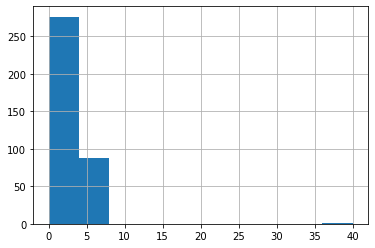

In [63]:
display(df.f_edu.unique())
display(df.f_edu.value_counts())
df.f_edu.hist()

значение 40 - явно ошибка, заменим его на 4

array([ 4.,  1.,  2.,  3., nan,  0.])

2.0    105
3.0     94
4.0     89
1.0     75
0.0      2
Name: f_edu, dtype: int64

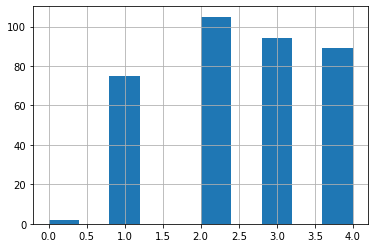

In [64]:
df.loc[df.f_edu == 40, ['f_edu']] = 4
display(df.f_edu.unique())
display(df.f_edu.value_counts())
df.f_edu.hist()

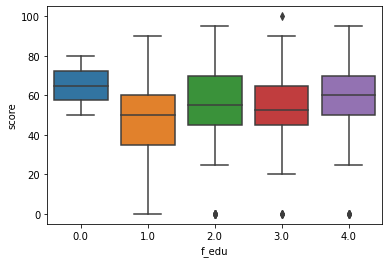

In [65]:
sns.boxplot(x='f_edu', y='score', data=df)

In [66]:
outliers_check(df.f_edu)

,f_edu,up_outliers,down_outliers
76,0.0,False,True
171,0.0,False,True


В целом у пап с высшим образованием похуже чем у мам. М.б. они были заняты поиском образованной жены?

##### Mjob
Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
Переменная категориальная.  
19 пропусков.

In [67]:
display(df.m_job.unique())
display(df.m_job.value_counts())

array(['at_home', 'health', 'other', 'services', 'teacher', nan],
      dtype=object)

other       127
services     98
at_home      58
teacher      55
health       32
Name: m_job, dtype: int64

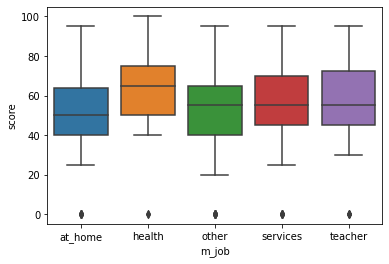

In [68]:
sns.boxplot(x='m_job', y='score', data=df)

По оценкам выделяются дети мед работников. Но их меньше всего.

#### Fjob
Fjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)  
Переменная категориальная. 37 пропусков.

In [69]:
display(df.f_job.unique())
display(df.f_job.value_counts())

array(['teacher', 'other', nan, 'health', 'services', 'at_home'],
      dtype=object)

other       194
services     99
teacher      29
at_home      16
health       15
Name: f_job, dtype: int64

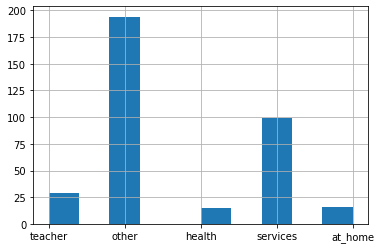

In [70]:
df.f_job.hist()

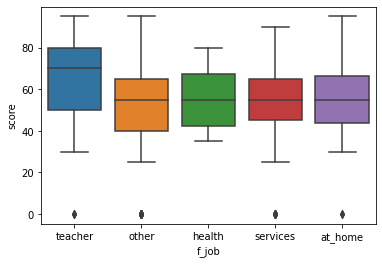

In [71]:
sns.boxplot(x='f_job', y='score', data=df)

Здесь по оценка выделяются дети учетилей.

Можно сказать, что папы меньше работают дома и учителями,  в отличие от мам, но это не имеет отношения к сути дела.

#### reason
reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)
Переменная категориальная.  
18 пропусков. 

In [72]:
display(df.reason.unique())
display(df.reason.value_counts())

array(['course', 'other', 'home', 'reputation', nan], dtype=object)

course        135
reputation    102
home          101
other          34
Name: reason, dtype: int64

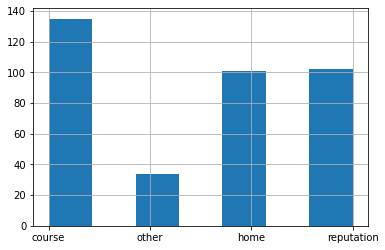

In [73]:
df.reason.hist(bins=7)

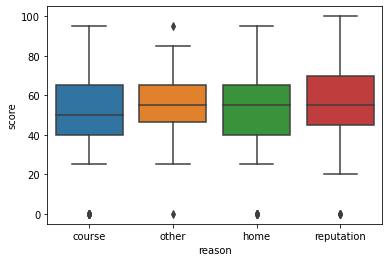

In [74]:
sns.boxplot(x='reason', y='score', data=df)

Сложно сказать влияет ли причина выбора школы на успеваемость.

#### guardian
guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)  
Переменная категориальная.  
32 пропуска

In [75]:
display(df.guardian.unique())
display(df.guardian.value_counts())

array(['mother', 'father', 'other', nan], dtype=object)

mother    248
father     86
other      24
Name: guardian, dtype: int64

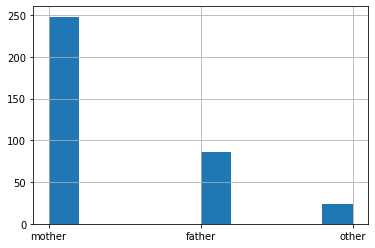

In [76]:
df.guardian.hist()

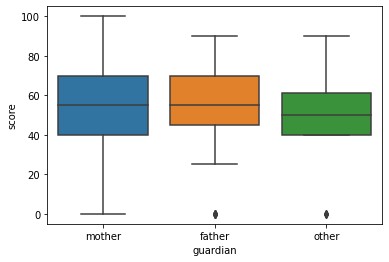

In [77]:
sns.boxplot(x='guardian', y='score', data=df)

#### traveltime
traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)  
Переменная числовая, ранговая.  
28 пропусков

In [78]:
display(df.traveltime.unique())
display(df.traveltime.value_counts())

array([ 2.,  1.,  3., nan,  4.])

1.0    239
2.0     94
3.0     21
4.0      7
Name: traveltime, dtype: int64

In [79]:
outliers_check(df.traveltime)

,traveltime,up_outliers,down_outliers
61,4.0,True,False
108,4.0,True,False
149,4.0,True,False
164,4.0,True,False
228,4.0,True,False
327,4.0,True,False
375,4.0,True,False


Т.к. переменная ранговая, выбросы удалять не будем.

Большинство учеников живёт рядом со школой.

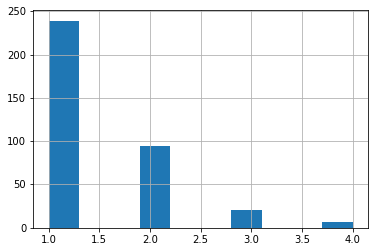

In [80]:
df.traveltime.hist()

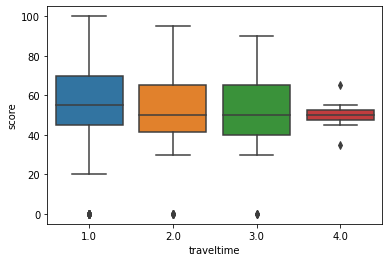

In [81]:
sns.boxplot(x='traveltime', y='score', data=df)

#### studytime
studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)  
Переменная числовая, ранговая.  
7 пропусков

In [82]:
display(df.studytime.unique())
display(df.studytime.value_counts())

array([ 2.,  3.,  1., nan,  4.])

2.0    189
1.0    103
3.0     63
4.0     27
Name: studytime, dtype: int64

In [83]:
outliers_check(df.studytime)

,studytime,up_outliers,down_outliers
47,4.0,True,False
66,4.0,True,False
67,4.0,True,False
69,4.0,True,False
70,4.0,True,False
71,4.0,True,False
76,4.0,True,False
77,4.0,True,False
94,4.0,True,False
95,4.0,True,False


Здесь так-же ранговая переменная, удалять целый ранг не вижу смысла.  

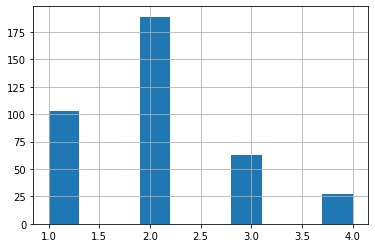

In [84]:
df.studytime.hist()

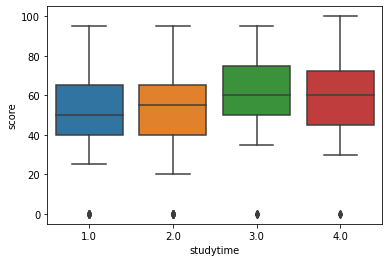

In [85]:
sns.boxplot(x='studytime', y='score', data=df)

Большинство учеников тратит на внекласную учёбу не более 5 часов в сутки.  
Наблюдается тенденция увеличения успеваемости от затраченного времени на учёбу вне школы.

#### failures
failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)  
Переменная числовая, ранговая.  
23 пропуска

In [86]:
display(df.failures.unique())
display(df.failures.value_counts())

array([ 0.,  3., nan,  2.,  1.])

0.0    290
1.0     48
2.0     15
3.0     14
Name: failures, dtype: int64

In [87]:
outliers_check(df.failures)

,failures,up_outliers,down_outliers
2,3.0,True,False
18,3.0,True,False
25,2.0,True,False
40,1.0,True,False
44,1.0,True,False
...,...,...,...
384,1.0,True,False
387,1.0,True,False
389,1.0,True,False
390,2.0,True,False


Три значения трёх рангов попадают под выбросы. Удалять не буду.

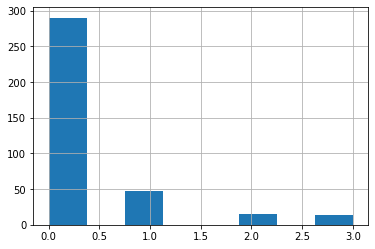

In [88]:
df.failures.hist(bins=8)

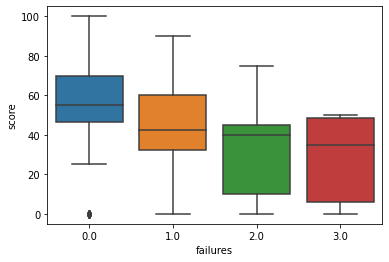

In [89]:
sns.boxplot(x='failures', y='score', data=df)

Наблюдается уменьшение успеваемости с увеличением количества внеучебных неудач.

#### schoolsup
schoolsup — дополнительная образовательная поддержка (yes или no)  
Категориальная переменная.  
10 пропусков

In [90]:
display(df.schoolsup.unique())
display(df.schoolsup.value_counts())

array(['yes', 'no', nan], dtype=object)

no     331
yes     49
Name: schoolsup, dtype: int64

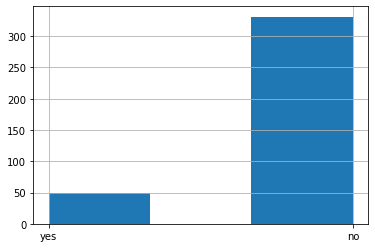

In [91]:
df.schoolsup.hist(bins=3)

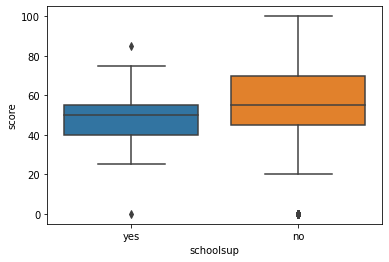

In [92]:
sns.boxplot(x='schoolsup', y='score', data=df)

In [93]:
no = df[df.schoolsup == 'no'].score.copy()
yes = df[df.schoolsup == 'yes'].score.copy()
print('no')
display(outliers_check(no))
print('yes')
outliers_check(yes)

no


,score,up_outliers,down_outliers
128,0.0,False,True
130,0.0,False,True
131,0.0,False,True
134,0.0,False,True
135,0.0,False,True
136,0.0,False,True
137,0.0,False,True
144,0.0,False,True
146,0.0,False,True
148,0.0,False,True


yes


,score,up_outliers,down_outliers
140,0.0,False,True
222,85.0,True,False


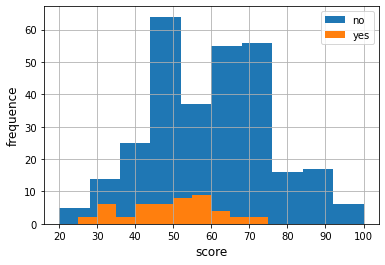

In [94]:
free_outliers_hist(no, 'no', 'score')
free_outliers_hist(yes, 'yes', 'score')

In [95]:
# оценимним есть ли статистически значимые различия в оценках между yes и no без выбросов.
weightstats.ttest_ind(delite_outliers(
    no), delite_outliers(yes))  # T test для выборки

(5.076618739270405, 6.34088672972889e-07, 340.0)

In [96]:
print(f'среднее значене оценок группы no = {delite_outliers(no).mean()}')
print(f'среднее значене оценок группы yes = {delite_outliers(yes).mean()}')

среднее значене оценок группы no = 59.610169491525426
среднее значене оценок группы yes = 47.234042553191486


Большинство учащихся не имеют дополнительной образовательной поддержки, и как это ни странно, у них значимо выше показатель оценки.

In [97]:
need_list.append('schoolsup')

#### famsup
famsup — семейная образовательная поддержка (yes или no)  
Категориальная переменная.  
39 пропусков

In [98]:
display(df.famsup.unique())
display(df.famsup.value_counts())

array(['no', 'yes', nan], dtype=object)

yes    216
no     135
Name: famsup, dtype: int64

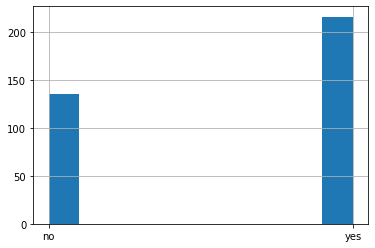

In [99]:
df.famsup.hist()

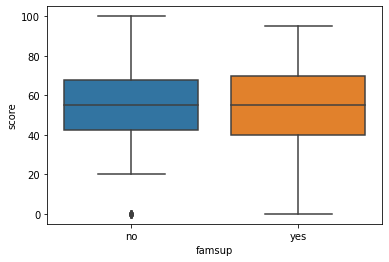

In [100]:
sns.boxplot(x='famsup', y='score', data=df)

In [101]:
no = df[df.famsup == 'no'].score.copy()
yes = df[df.famsup == 'yes'].score.copy()
print('no')
display(outliers_check(no))
print('yes')
outliers_check(yes)

no


,score,up_outliers,down_outliers
136,0.0,False,True
150,0.0,False,True
160,0.0,False,True
162,0.0,False,True
173,0.0,False,True
239,0.0,False,True
242,0.0,False,True
259,0.0,False,True
310,0.0,False,True
332,0.0,False,True


yes
Выбросы не найдены


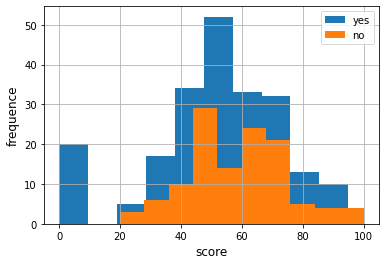

In [102]:
free_outliers_hist(yes, 'yes', 'score')
free_outliers_hist(no, 'no', 'score')

In [103]:
# оценимним есть ли статистически значимые различия в оценках между yes и no без выбросов.
weightstats.ttest_ind(delite_outliers(
    no), delite_outliers(yes))  # T test для выборки

(2.898370500278022, 0.003999014455257364, 334.0)

In [104]:
print(f'среднее значене оценок группы no = {delite_outliers(no).mean()}')
print(f'среднее значене оценок группы yes = {delite_outliers(yes).mean()}')

среднее значене оценок группы no = 58.583333333333336
среднее значене оценок группы yes = 51.71296296296296


Более чем половине учачихся помогают дома с учёбой. Однако оценки на экзамене у них значимо ниже чем у самостоятельных учеников. Наблюдается тенденция...

In [105]:
need_list.append('famsup')

#### paid
paid — дополнительные платные занятия по математике (yes или no)  
Категориальная переменная.  
40 пропусков

In [106]:
display(df.paid.unique())
display(df.paid.value_counts())

array(['no', nan, 'yes'], dtype=object)

no     197
yes    153
Name: paid, dtype: int64

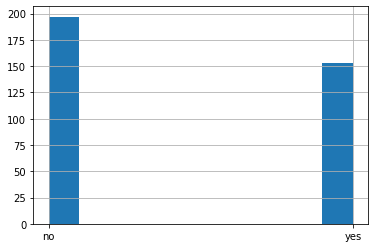

In [107]:
df.paid.hist()

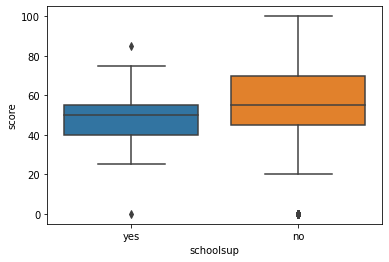

In [108]:
sns.boxplot(x='schoolsup', y='score', data=df)

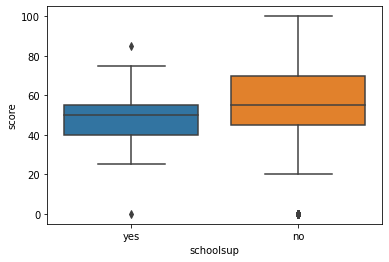

In [109]:
sns.boxplot(x='schoolsup', y='score', data=df)

In [110]:
no = df[df.paid == 'no'].score.copy()
yes = df[df.paid == 'yes'].score.copy()
print('no')
display(outliers_check(no))
print('yes')
outliers_check(yes)

no
Выбросы не найдены


None

yes


,score,up_outliers,down_outliers
168,0.0,False,True
259,0.0,False,True
264,0.0,False,True
296,0.0,False,True
316,0.0,False,True
337,0.0,False,True
367,0.0,False,True


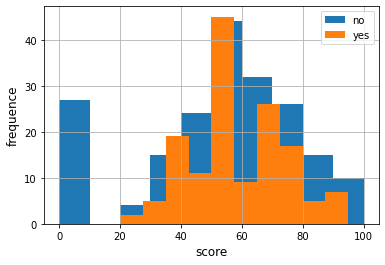

In [111]:
free_outliers_hist(no, 'no', 'score')
free_outliers_hist(yes, 'yes', 'score')

In [112]:
# оценимним есть ли статистически значимые различия в оценках между yes и no без выбросов.
weightstats.ttest_ind(delite_outliers(
    no), delite_outliers(yes))  # T test для выборки

(-3.0574872740000334, 0.002408408256306475, 341.0)

In [113]:
print(f'среднее значене оценок группы no = {delite_outliers(no).mean()}')
print(f'среднее значене оценок группы yes = {delite_outliers(yes).mean()}')

среднее значене оценок группы no = 50.35532994923858
среднее значене оценок группы yes = 57.636986301369866


Ученики, которые брали дополнительные платные занятия по предмету в среднем успешнее на экзамене.

In [114]:
need_list.append('paid')

#### activities
activities — дополнительные внеучебные занятия (yes или no)  
Категориальная переменная.   
14 пропусков

In [115]:
display(df.activities.unique())
display(df.activities.value_counts())

array(['no', 'yes', nan], dtype=object)

yes    192
no     183
Name: activities, dtype: int64

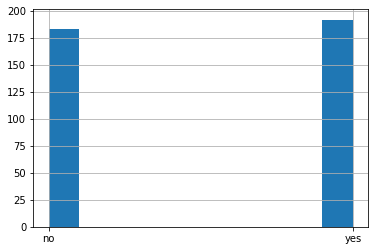

In [116]:
df.activities.hist()

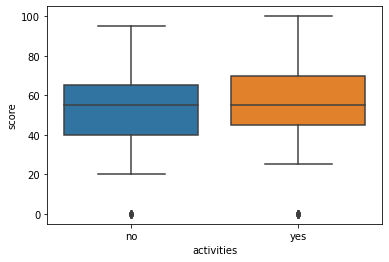

In [117]:
sns.boxplot(x='activities', y='score', data=df)

In [118]:
no = df[df.activities == 'no'].score.copy()
yes = df[df.activities == 'yes'].score.copy()
print('no')
display(outliers_check(no))
print('yes')
outliers_check(yes)

no


,score,up_outliers,down_outliers
130,0.0,False,True
134,0.0,False,True
136,0.0,False,True
144,0.0,False,True
146,0.0,False,True
148,0.0,False,True
150,0.0,False,True
153,0.0,False,True
168,0.0,False,True
239,0.0,False,True


yes


,score,up_outliers,down_outliers
128,0.0,False,True
131,0.0,False,True
135,0.0,False,True
137,0.0,False,True
162,0.0,False,True
170,0.0,False,True
173,0.0,False,True
221,0.0,False,True
242,0.0,False,True
259,0.0,False,True


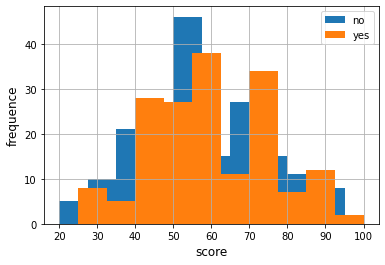

In [119]:
free_outliers_hist(no, 'no', 'score')
free_outliers_hist(yes, 'yes', 'score')

In [120]:
# оценимним есть ли статистически значимые различия в оценках между yes и no без выбросов.
weightstats.ttest_ind(delite_outliers(
    no), delite_outliers(yes))  # T test для выборки

(-1.1052268629252946, 0.26984739556215265, 338.0)

In [121]:
print(f'среднее значене оценок группы no = {delite_outliers(no).mean()}')
print(f'среднее значене оценок группы yes = {delite_outliers(yes).mean()}')

среднее значене оценок группы no = 56.845238095238095
среднее значене оценок группы yes = 58.80813953488372


Приблизительно равное значение распределения показателя _непизвестных_ дополнительных внеучебных занятий.
На итоговоую оценку не влияет.

In [122]:
trash_list.append('activities')
trash_list

['school', 'sex', 'activities']

#### nursery
nursery — посещал детский сад (yes или no)  
Категориальная переменная.  
15 пропусков

In [123]:
display(df.nursery.unique())
display(df.nursery.value_counts())

array(['yes', 'no', nan], dtype=object)

yes    297
no      77
Name: nursery, dtype: int64

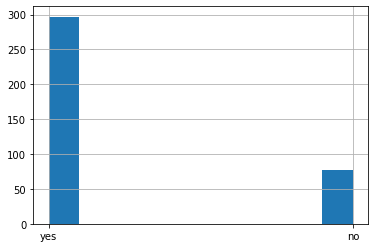

In [124]:
df.nursery.hist()

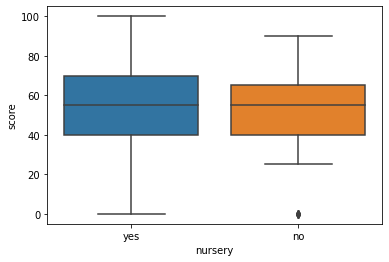

In [125]:
sns.boxplot(x='nursery', y='score', data=df)

In [126]:
no = df[df.nursery == 'no'].score.copy()
yes = df[df.nursery == 'yes'].score.copy()
print('no')
display(outliers_check(no))
print('yes')
outliers_check(yes)

no


,score,up_outliers,down_outliers
131,0.0,False,True
137,0.0,False,True
168,0.0,False,True
170,0.0,False,True
173,0.0,False,True
242,0.0,False,True
310,0.0,False,True
333,0.0,False,True
387,0.0,False,True


yes
Выбросы не найдены


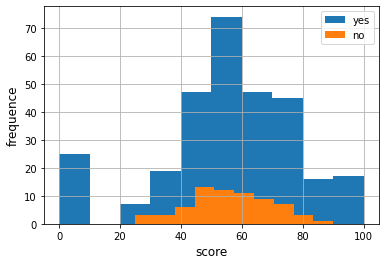

In [127]:
free_outliers_hist(yes, 'yes', 'score')
free_outliers_hist(no, 'no', 'score')

In [128]:
# оценимним есть ли статистически значимые различия в оценках между yes и no без выбросов.
weightstats.ttest_ind(delite_outliers(
    no), delite_outliers(yes))  # T test для выборки

(1.2708240788945824, 0.2046050440668301, 363.0)

Нулевая гипотеза не отвергается, следовательно посещение детского сада не сказывается на оценку по математике.

In [129]:
trash_list.append('nursery')
trash_list

['school', 'sex', 'activities', 'nursery']

#### higher 
higher — хочет получить высшее образование (yes или no)  
Категориальная переменная.  
20 пропусков

In [130]:
display(df.higher.unique())
display(df.higher.value_counts())

array(['yes', nan, 'no'], dtype=object)

yes    350
no      19
Name: higher, dtype: int64

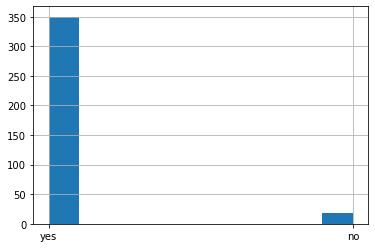

In [131]:
df.higher.hist()

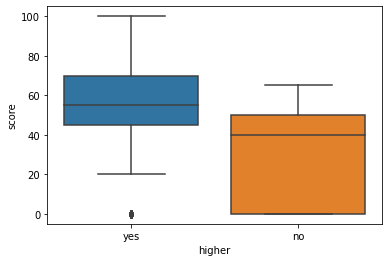

In [132]:
sns.boxplot(x='higher', y='score', data=df)

In [133]:
no = df[df.higher == 'no'].score.copy()
yes = df[df.higher == 'yes'].score.copy()
print('no')
display(outliers_check(no))
print('yes')
outliers_check(yes)

no
Выбросы не найдены


None

yes


,score,up_outliers,down_outliers
128,0.0,False,True
130,0.0,False,True
131,0.0,False,True
134,0.0,False,True
135,0.0,False,True
136,0.0,False,True
137,0.0,False,True
140,0.0,False,True
144,0.0,False,True
146,0.0,False,True


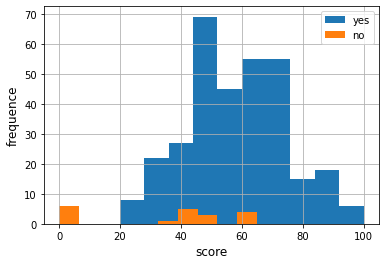

In [134]:
free_outliers_hist(yes, 'yes', 'score')
free_outliers_hist(no, 'no', 'score')

In [135]:
# оценимним есть ли статистически значимые различия в оценках между yes и no без выбросов.
weightstats.ttest_ind(delite_outliers(
    no), delite_outliers(yes))  # T test для выборки

(-6.058543802886835, 3.6725768910858153e-09, 337.0)

In [136]:
print(f'среднее значене оценок группы no = {delite_outliers(no).mean()}')
print(f'среднее значене оценок группы yes = {delite_outliers(yes).mean()}')

среднее значене оценок группы no = 33.68421052631579
среднее значене оценок группы yes = 58.078125


Судя по резулльтатам Т-теста, желающие получить высшее образование, лучше изучали предмет.

In [137]:
need_list.append('higher')

#### internet
internet — наличие интернета дома (yes или no)  
Категориальная переменная.  
34 пропуска

In [138]:
display(df.internet.unique())
display(df.internet.value_counts())

array([nan, 'yes', 'no'], dtype=object)

yes    300
no      55
Name: internet, dtype: int64

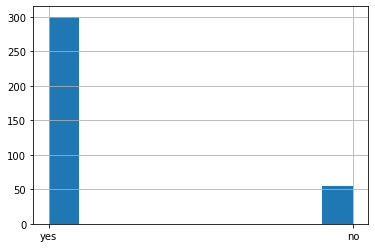

In [139]:
df.internet.hist()

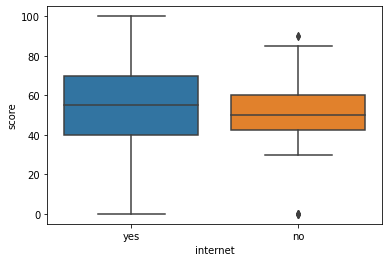

In [140]:
sns.boxplot(x='internet', y='score', data=df)

In [141]:
no = df[df.internet == 'no'].score.copy()
yes = df[df.internet == 'yes'].score.copy()
print('no')
display(outliers_check(no))
print('yes')
outliers_check(yes)

no


,score,up_outliers,down_outliers
134,0.0,False,True
136,0.0,False,True
221,0.0,False,True
293,90.0,True,False
306,90.0,True,False
310,0.0,False,True
334,0.0,False,True
383,0.0,False,True


yes
Выбросы не найдены


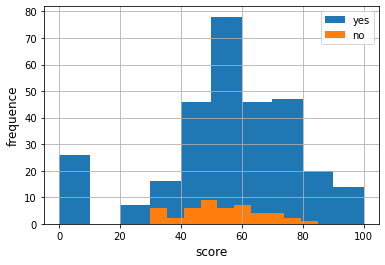

In [142]:
free_outliers_hist(yes, 'yes', 'score')
free_outliers_hist(no, 'no', 'score')

In [143]:
# оценимним есть ли статистически значимые различия в оценках между yes и no без выбросов.
weightstats.ttest_ind(delite_outliers(
    no), delite_outliers(yes))  # T test для выборки

(0.14746394814362643, 0.8828519742856953, 345.0)

Судя по резулльтатам Т-теста, наличие/отсутствие интернета не влияет на знание математики.

In [144]:
trash_list.append('internet')
trash_list

['school', 'sex', 'activities', 'nursery', 'internet']

#### romantic
romantic — в романтических отношениях (yes или no)  
Категориальная переменная.
31 пропуск

In [145]:
display(df.romantic.unique())
display(df.romantic.value_counts())

array(['no', nan, 'yes'], dtype=object)

no     235
yes    123
Name: romantic, dtype: int64

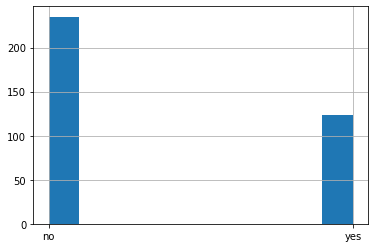

In [146]:
df.romantic.hist()

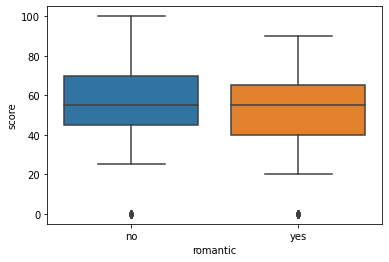

In [147]:
sns.boxplot(x='romantic', y='score', data=df)

In [148]:
no = df[df.romantic == 'no'].score.copy()
yes = df[df.romantic == 'yes'].score.copy()
print('no')
display(outliers_check(no))
print('yes')
outliers_check(yes)

no


,score,up_outliers,down_outliers
128,0.0,False,True
136,0.0,False,True
140,0.0,False,True
144,0.0,False,True
146,0.0,False,True
168,0.0,False,True
170,0.0,False,True
242,0.0,False,True
296,0.0,False,True
316,0.0,False,True


yes


,score,up_outliers,down_outliers
130,0.0,False,True
131,0.0,False,True
134,0.0,False,True
135,0.0,False,True
137,0.0,False,True
148,0.0,False,True
150,0.0,False,True
153,0.0,False,True
160,0.0,False,True
173,0.0,False,True


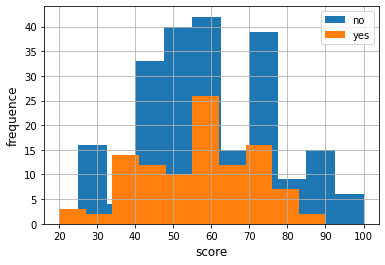

In [149]:
free_outliers_hist(no, 'no', 'score')
free_outliers_hist(yes, 'yes', 'score')

In [150]:
# оценимним есть ли статистически значимые различия в оценках между yes и no без выбросов.
weightstats.ttest_ind(delite_outliers(
    no), delite_outliers(yes))  # T test для выборки

(1.1123001147407718, 0.26684145093612865, 321.0)

Судя по резулльтатам Т-теста, наличие/отсутствие романтических отношений не влияет на знание математики.

In [151]:
trash_list.append('romantic')
trash_list

['school', 'sex', 'activities', 'nursery', 'internet', 'romantic']

#### famrel
famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)  
Переменная числовая, ранговая.  
27 пропусков

In [152]:
display(df.famrel.unique())
display(df.famrel.value_counts())

array([ 4.,  5.,  3., nan, -1.,  2.,  1.])

 4.0    178
 5.0     97
 3.0     62
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64

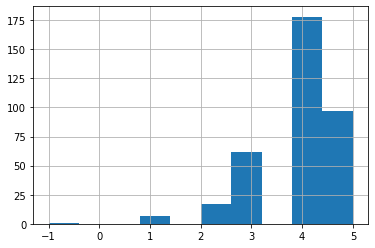

In [153]:
df.famrel.hist()

-1 явная ошибка, исправим на 1

In [154]:
df.loc[df.famrel == -1, ['famrel']] = 1

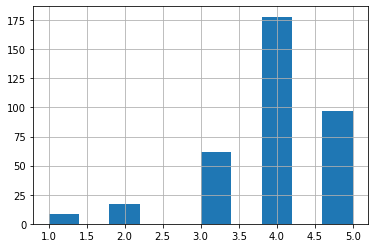

In [155]:
df.famrel.hist()

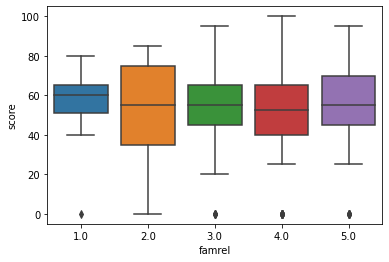

In [156]:
sns.boxplot(x='famrel', y='score', data=df)

#### freetime
freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)  
Переменная числовая, ранговая.  
9 пропусков

In [157]:
display(df.freetime.unique())
display(df.freetime.value_counts())

array([ 3.,  2.,  4.,  1.,  5., nan])

3.0    152
4.0    110
2.0     63
5.0     37
1.0     18
Name: freetime, dtype: int64

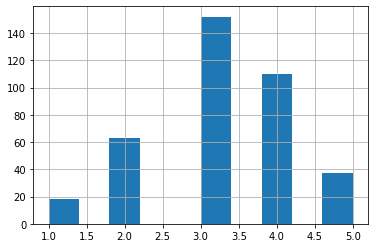

In [158]:
df.freetime.hist()

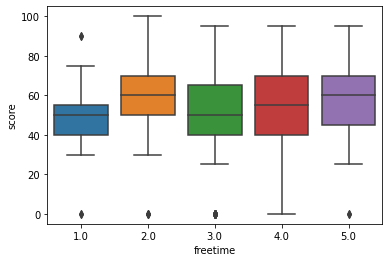

In [159]:
sns.boxplot(x='freetime', y='score', data=df)

#### goout
goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)  
Переменная числовая, ранговая.  
7 пропусков

In [160]:
display(df.goout.unique())
display(df.goout.value_counts())

array([ 4.,  3.,  2.,  1.,  5., nan])

3.0    126
2.0    101
4.0     81
5.0     51
1.0     23
Name: goout, dtype: int64

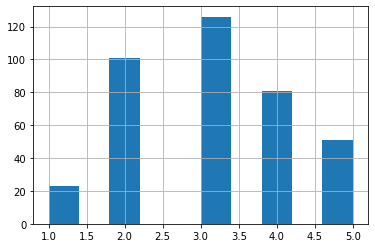

In [161]:
df.goout.hist()

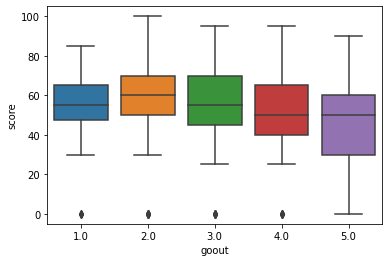

In [162]:
sns.boxplot(x='goout', y='score', data=df)

Судя по распределению свободного времени и проведению времени с друзьями, эти показатели должны неплохо коррелировать, оценим позже.

#### health
health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)
Переменная числовая, ранговая.  
15 пропусков

In [163]:
display(df.health.unique())
display(df.health.value_counts())

array([ 3.,  5.,  1.,  2.,  4., nan])

5.0    137
3.0     88
4.0     60
1.0     47
2.0     42
Name: health, dtype: int64

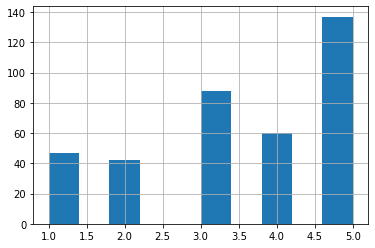

In [164]:
df.health.hist()

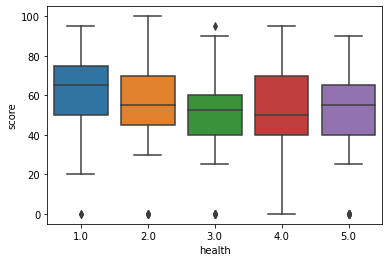

In [165]:
sns.boxplot(x='health', y='score', data=df)

#### absences 
absences — количество пропущенных занятий  
Переменная числовая  
11 пропусков

In [166]:
display(df.absences.unique())
display(df.absences.value_counts())

array([  6.,   4.,  10.,   2.,   0.,  16.,  nan,  14.,   7.,   8.,  25.,
        12.,  54.,  18.,  26.,  20.,  56.,  24.,  28.,   5.,  13.,  15.,
        22.,   3., 385.,  21.,   1.,  75.,  30.,  19.,   9.,  11.,  38.,
        40.,  23.,  17., 212.])

0.0      110
2.0       60
4.0       52
6.0       30
8.0       20
10.0      17
12.0      12
14.0      12
3.0        7
16.0       7
7.0        6
5.0        5
18.0       5
20.0       4
22.0       3
9.0        3
1.0        3
15.0       2
13.0       2
11.0       2
25.0       1
54.0       1
385.0      1
26.0       1
56.0       1
24.0       1
212.0      1
21.0       1
75.0       1
30.0       1
19.0       1
38.0       1
40.0       1
23.0       1
17.0       1
28.0       1
Name: absences, dtype: int64

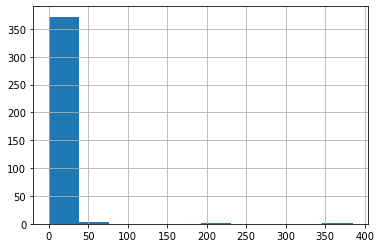

In [167]:
df.absences.hist()

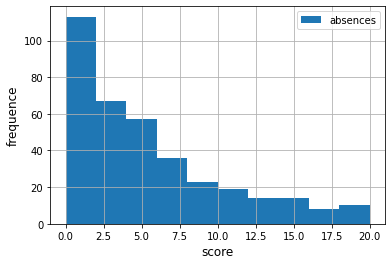

In [168]:
free_outliers_hist(df.absences, 'absences', 'score')

Всё что выше 20 пропущенных часов - выбросы, удалим их.  
Распределение экспаненциальное.

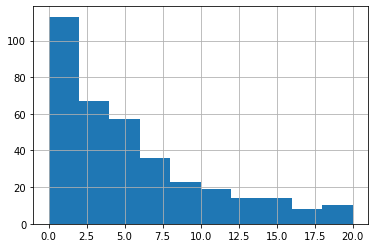

In [169]:
df.absences = delite_outliers(df.absences)
df.absences.hist()

#### studytime, granular
Переменная загадка, смысл переменной неизвестен.  
Переменная числовая.  
7 пропусков

In [170]:
display(df.studytime_granular.unique())
display(df.studytime_granular.value_counts())

array([ -6.,  -9.,  -3.,  nan, -12.])

-6.0     189
-3.0     103
-9.0      63
-12.0     27
Name: studytime_granular, dtype: int64

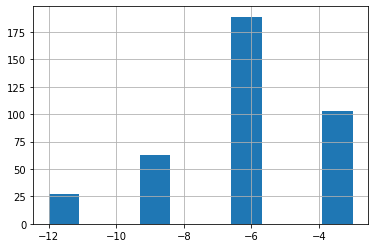

In [171]:
df.studytime_granular.hist()

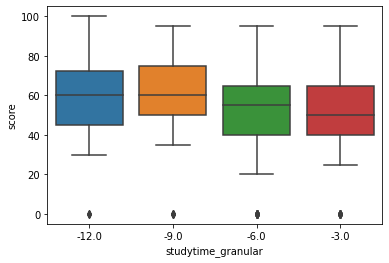

In [172]:
sns.boxplot(x='studytime_granular', y='score', data=df)

### 3 Корреляционный анализ количественных переменных

In [173]:
df.corr()

,age,m_edu,f_edu,traveltime,studytime,failures,studytime_granular,famrel,freetime,goout,health,absences,score
age,1.000000,-0.146736,-0.152148,0.073146,-0.018227,0.205919,0.018227,0.058768,0.016099,0.121115,-0.068103,0.155469,-0.155726
m_edu,-0.146736,1.000000,0.621981,-0.165838,0.081032,-0.240319,-0.081032,-0.003697,0.038265,0.072320,-0.048331,0.066439,0.213349
f_edu,-0.152148,0.621981,1.000000,-0.132036,0.017306,-0.273286,-0.017306,-0.016791,-0.017263,0.050997,0.018624,-0.024235,0.130923
traveltime,0.073146,-0.165838,-0.132036,1.000000,-0.105910,0.049738,0.105910,-0.032413,-0.026299,0.032629,-0.011724,-0.050613,-0.070559
studytime,-0.018227,0.081032,0.017306,-0.105910,1.000000,-0.181947,-1.000000,0.039899,-0.125066,-0.053831,-0.079180,-0.075454,0.115741
failures,0.205919,-0.240319,-0.273286,0.049738,-0.181947,1.000000,0.181947,-0.021068,0.091608,0.107747,0.088013,0.076537,-0.344338
studytime_granular,0.018227,-0.081032,-0.017306,0.105910,-1.000000,0.181947,1.000000,-0.039899,0.125066,0.053831,0.079180,0.075454,-0.115741
famrel,0.058768,-0.003697,-0.016791,-0.032413,0.039899,-0.021068,-0.039899,1.000000,0.171165,0.072291,0.089074,-0.092902,0.055305
freetime,0.016099,0.038265,-0.017263,-0.026299,-0.125066,0.091608,0.125066,0.171165,1.000000,0.296338,0.064315,0.096281,0.019026
goout,0.121115,0.072320,0.050997,0.032629,-0.053831,0.107747,0.053831,0.072291,0.296338,1.000000,-0.018026,0.113048,-0.129685


Переменную studytime_granular удалим, т.к. коэффицент корреляции с переменной studytime = -1.  
f_edu и m_edu достаточно сильно коррелирует 0.62, возможно можно заполнить пропуски в переменных.

In [174]:
df = df.drop(columns='studytime_granular')

In [175]:
df.corr()

,age,m_edu,f_edu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
age,1.000000,-0.146736,-0.152148,0.073146,-0.018227,0.205919,0.058768,0.016099,0.121115,-0.068103,0.155469,-0.155726
m_edu,-0.146736,1.000000,0.621981,-0.165838,0.081032,-0.240319,-0.003697,0.038265,0.072320,-0.048331,0.066439,0.213349
f_edu,-0.152148,0.621981,1.000000,-0.132036,0.017306,-0.273286,-0.016791,-0.017263,0.050997,0.018624,-0.024235,0.130923
traveltime,0.073146,-0.165838,-0.132036,1.000000,-0.105910,0.049738,-0.032413,-0.026299,0.032629,-0.011724,-0.050613,-0.070559
studytime,-0.018227,0.081032,0.017306,-0.105910,1.000000,-0.181947,0.039899,-0.125066,-0.053831,-0.079180,-0.075454,0.115741
failures,0.205919,-0.240319,-0.273286,0.049738,-0.181947,1.000000,-0.021068,0.091608,0.107747,0.088013,0.076537,-0.344338
famrel,0.058768,-0.003697,-0.016791,-0.032413,0.039899,-0.021068,1.000000,0.171165,0.072291,0.089074,-0.092902,0.055305
freetime,0.016099,0.038265,-0.017263,-0.026299,-0.125066,0.091608,0.171165,1.000000,0.296338,0.064315,0.096281,0.019026
goout,0.121115,0.072320,0.050997,0.032629,-0.053831,0.107747,0.072291,0.296338,1.000000,-0.018026,0.113048,-0.129685
health,-0.068103,-0.048331,0.018624,-0.011724,-0.079180,0.088013,0.089074,0.064315,-0.018026,1.000000,-0.013156,-0.070460


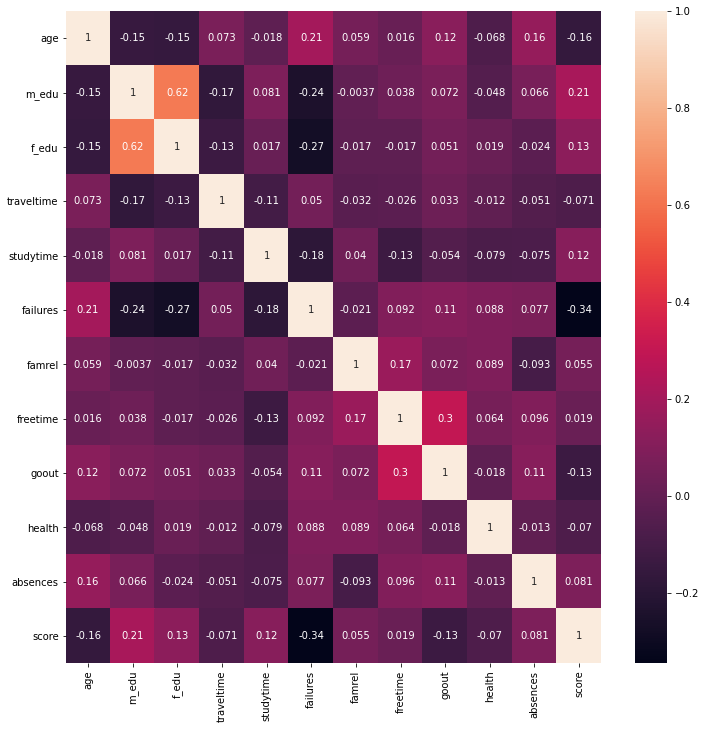

In [176]:
sns.heatmap(df.corr(), annot=True)
plt.gcf().set_size_inches(12, 12)

In [177]:
df.loc[df.f_edu.isna(), ['f_edu', 'm_edu']]

,f_edu,m_edu
21,NaN,4.0
42,NaN,4.0
46,NaN,3.0
57,NaN,4.0
58,NaN,1.0
67,NaN,3.0
137,NaN,3.0
142,NaN,4.0
159,NaN,3.0
161,NaN,3.0


Во всех строках, где есть пропущенные значения в образовании у пап, нет пропусков у мам.  
Значит заменим пропуски у пап значениями мам и наоборот.

In [178]:
index_list = df.loc[df.f_edu.isna(), ['f_edu']].index
for index in index_list:
    df.loc[index, 'f_edu'] = df.loc[index, 'm_edu']
df.loc[index_list, 'f_edu']

21     4.0
42     4.0
46     3.0
57     4.0
58     1.0
67     3.0
137    3.0
142    4.0
159    3.0
161    3.0
180    4.0
195    2.0
232    4.0
236    2.0
259    2.0
280    4.0
281    3.0
286    2.0
287    1.0
290    4.0
310    1.0
328    4.0
349    3.0
374    4.0
Name: f_edu, dtype: float64

In [179]:
index_list = df.loc[df.m_edu.isna(), ['m_edu']].index
for index in index_list:
    df.loc[index, 'm_edu'] = df.loc[index, 'f_edu']
df.loc[index_list, 'm_edu']

92     1.0
193    3.0
239    2.0
Name: m_edu, dtype: float64

### 4 Отбираем нужные для дальнейшего анализа переменные

In [180]:
trash_list

['school', 'sex', 'activities', 'nursery', 'internet', 'romantic']

Удалим из датасета `trash_list` - категориальные переменные, которые не влияют на целевую переменную по результатам Т-теста с исключением выбросов.

In [181]:
need_list

['age',
 'address',
 'famsize',
 'p_status',
 'schoolsup',
 'famsup',
 'paid',
 'higher']

In [182]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'p_status', 'm_edu',
       'f_edu', 'm_job', 'f_job', 'reason', 'guardian', 'traveltime',
       'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime',
       'goout', 'health', 'absences', 'score'],
      dtype='object')

In [183]:
df = df.drop(columns=trash_list)

In [184]:
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(delite_outliers(df.loc[df.loc[:, column] == comb[0], 'score']),
                     delite_outliers(df.loc[df.loc[:, column] == comb[1], 'score'])).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [185]:
for col in ['m_edu', 'f_edu', 'reason', 'guardian', 'traveltime', 'studytime',
            'failures', 'famrel', 'freetime', 'goout', 'health']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки m_edu
Найдены статистически значимые различия для колонки f_edu
Найдены статистически значимые различия для колонки studytime
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки goout


Переменную absences исключим из дальнейшего анализа в силу её незначительной корреляции с итоговой оценкой, коэффициент корреляции = 0.08  
Переменные 'm_edu', 'f_edu', 'failures', 'studytime', 'goout' добавим в список нужных, т.к. по результатам Т-теста они влияют на ключевую - 'score', её тоже добавим, без неё никак.  
Переменная 'age' включнена в список нужных по условию задания, хотя она и слабо коррелирует с оценкой 'score'.

In [189]:
need_list += ['m_edu', 'f_edu', 'failures', 'studytime', 'goout', 'score']
need_list

['age',
 'address',
 'famsize',
 'p_status',
 'schoolsup',
 'famsup',
 'paid',
 'higher',
 'm_edu',
 'f_edu',
 'failures',
 'studytime',
 'goout',
 'score']

In [190]:
df_for_model = df.loc[:, need_list]

In [191]:
df_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        389 non-null    int64  
 1   address    374 non-null    object 
 2   famsize    362 non-null    object 
 3   p_status   344 non-null    object 
 4   schoolsup  380 non-null    object 
 5   famsup     351 non-null    object 
 6   paid       350 non-null    object 
 7   higher     369 non-null    object 
 8   m_edu      389 non-null    float64
 9   f_edu      389 non-null    float64
 10  failures   367 non-null    float64
 11  studytime  382 non-null    float64
 12  goout      382 non-null    float64
 13  score      389 non-null    float64
dtypes: float64(6), int64(1), object(7)
memory usage: 55.6+ KB


#### 5 Выводы
Их исходного набора данных, для дальнейшего анализа выбрано 14 переменных.  
7 из них категориальные, 5 - числовые-ранговые и 2 числовые.  
Только в 4 переменных имеются все данные.  
В остальных отсутвие значений может достигать 10%.